C:\Users\USER\AppData\Local\Temp\ipykernel_2268\2781655877.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['Status'] = x['Status'].replace({'Developed': 1, 'Developing': 0})


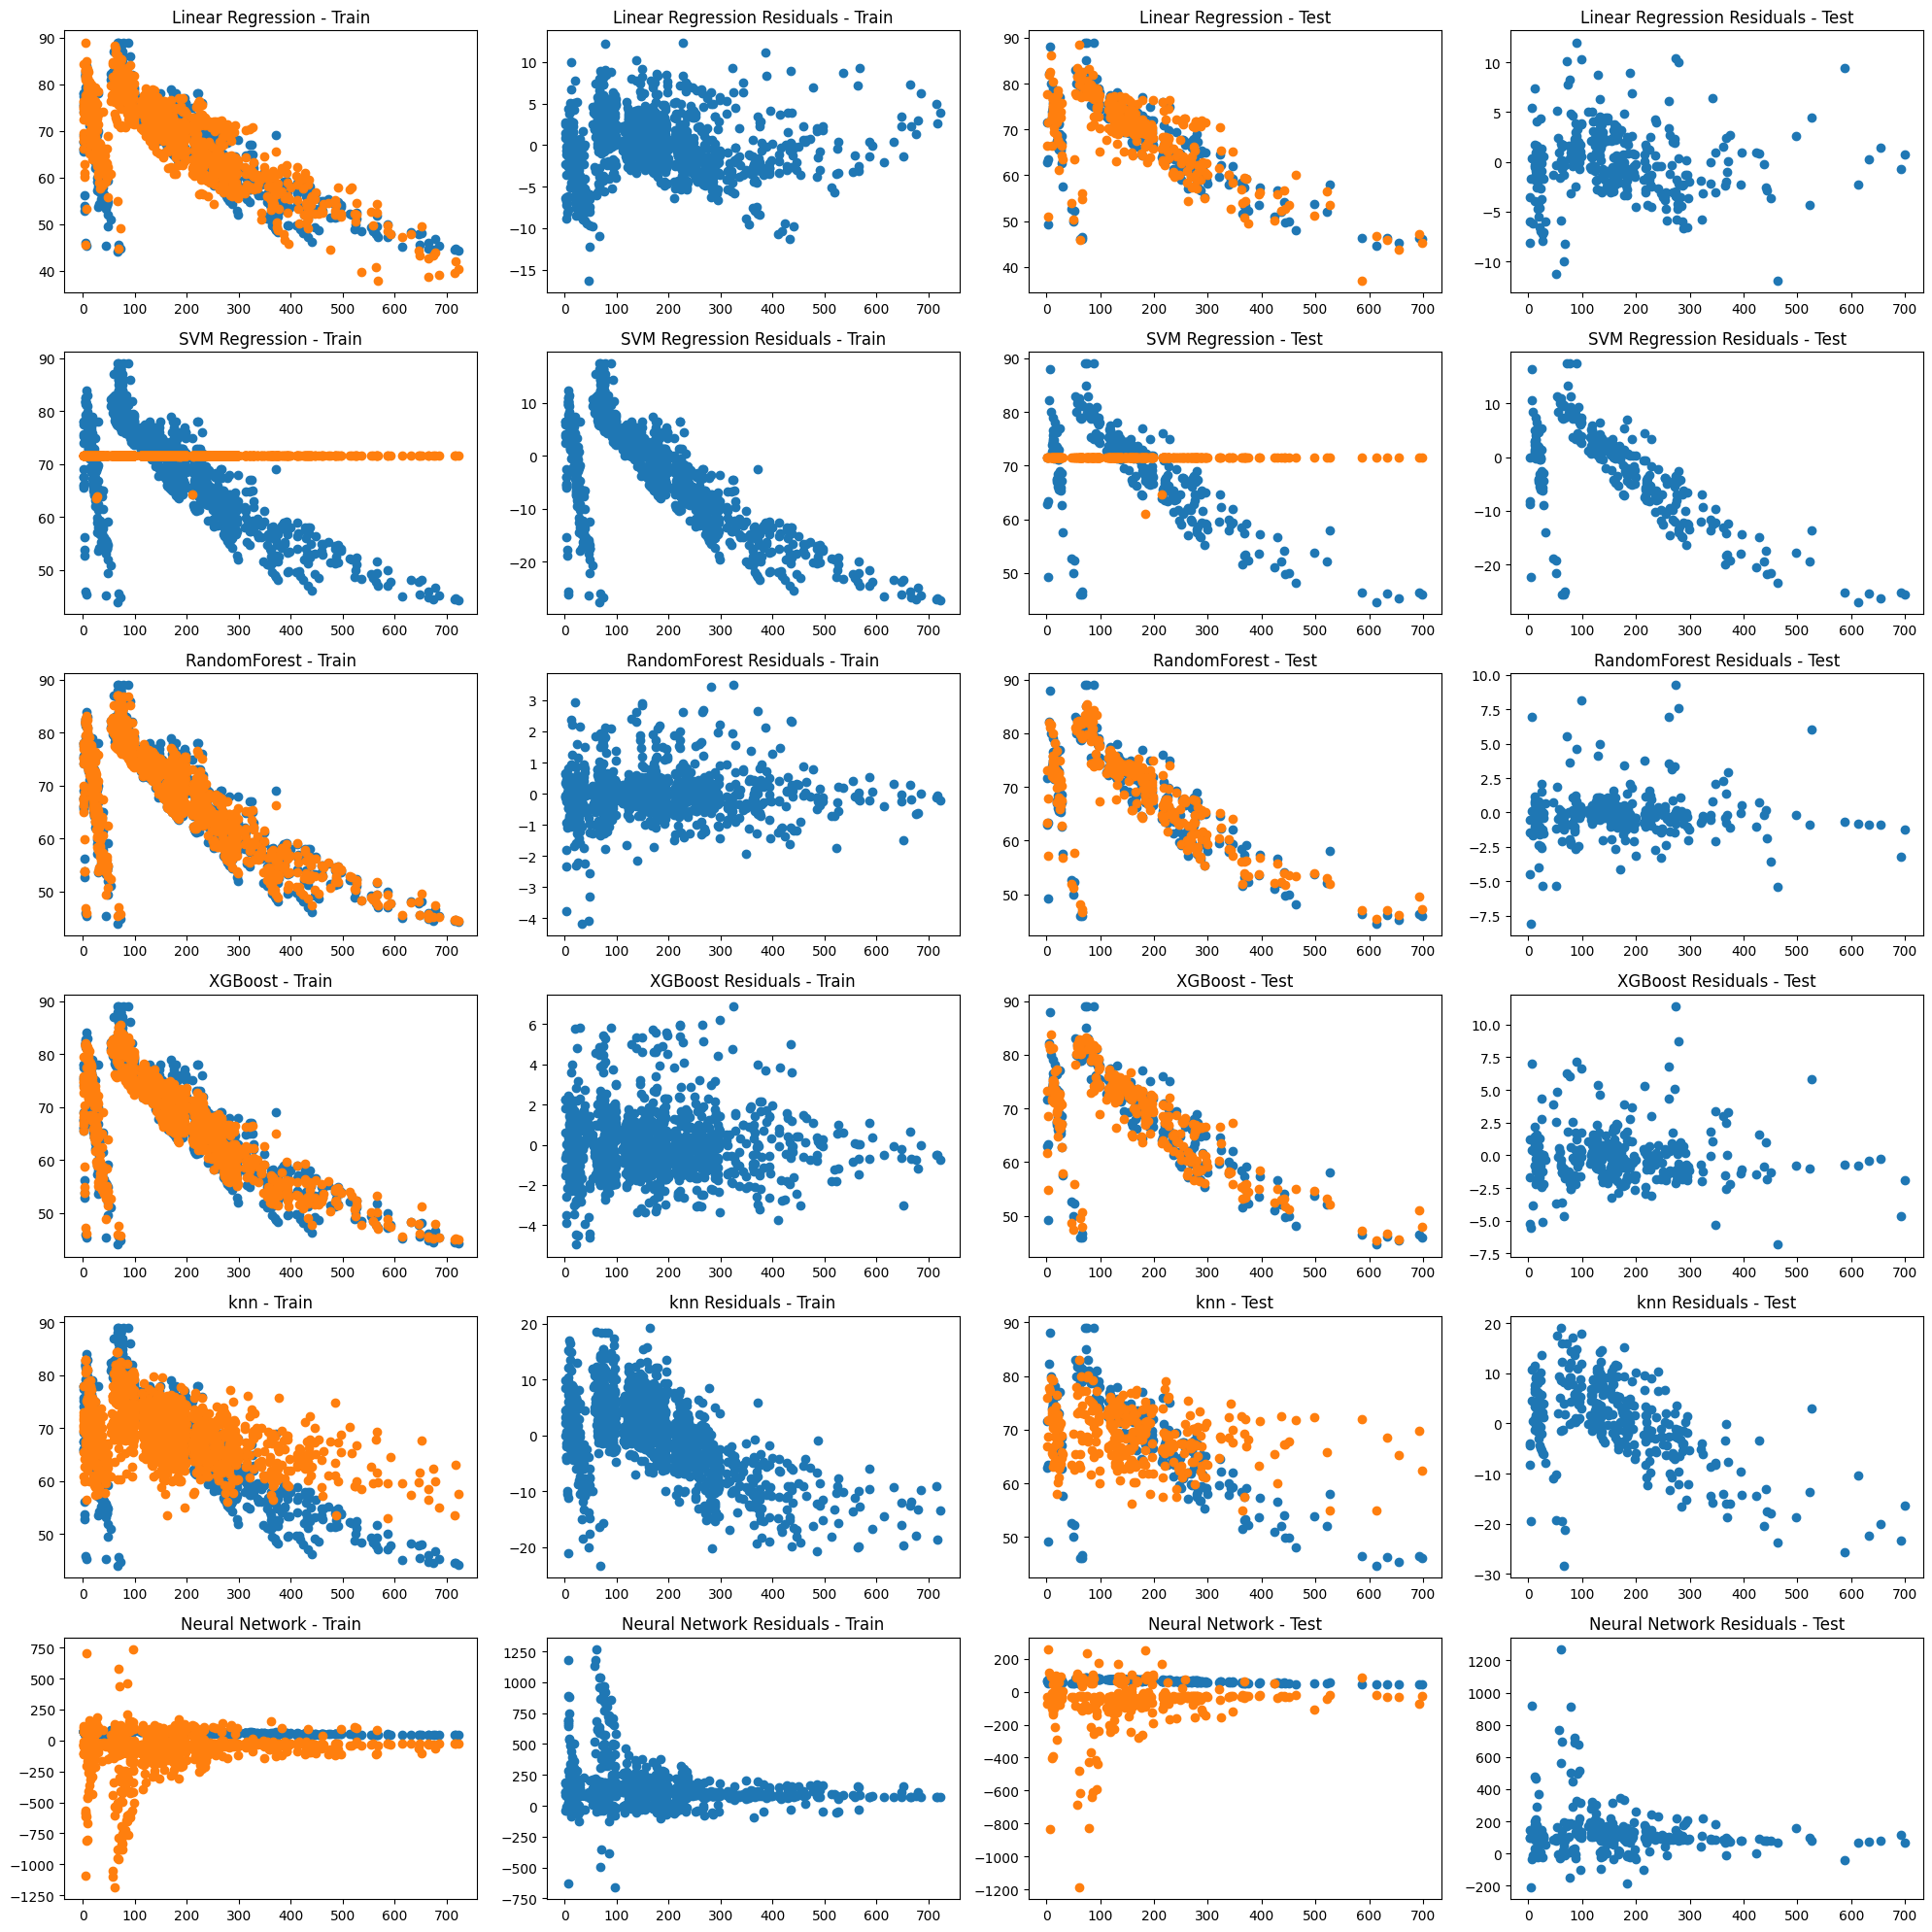

Metrics - Train Data:

                          error   R-squared           MSE  Durbin-Watson   Jarque-Bera     JB P-value
Linear Regression -1.415330e-10    0.838487     12.656345       1.950864     30.366697   2.546570e-07
SVM Regression    -3.021002e+03   -0.066644     83.583526       1.888943     79.701348   4.932557e-18
RandomForest      -2.271200e+01    0.994045      0.466628       1.956712   2346.299120   0.000000e+00
XGBoost            6.515677e-12    0.968619      2.459034       1.964356    498.709146  5.089616e-109
knn                1.388000e+02    0.390592     47.753931       1.984674     40.329113   1.748414e-09
Neural Network     1.748881e+05 -546.041962  42866.856438       1.217319  12979.007116   0.000000e+00
-------------------------------------------------
Metrics - Test Data:

                          error   R-squared           MSE  Durbin-Watson  Jarque-Bera     JB P-value
Linear Regression    -12.239651    0.835703     12.033623       2.026247    26.276642   1.

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


def zscore_normalize_features(X):
    # find the mean of each column/feature
    mu     = np.nanmean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.nanstd(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return X_norm,mu,sigma


data = pd.read_excel(io='LifeExpectancyDataset.xlsx')
data.dropna(axis=0, inplace=True)
# data.fillna(0, inplace=True)
# print(data)
x=data.drop(columns=['Life expectancy','Country'])
y=data['Life expectancy']

x['Status'] = x['Status'].replace({'Developed': 1, 'Developing': 0})

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=10)
X_train,mu1,sigma1=zscore_normalize_features(X_train)
X_test,mu2,sigma2=zscore_normalize_features(X_test)

algorithms = {
    'Linear Regression': LinearRegression(),
    'SVM Regression': SVR(kernel='poly'),  # Adjust kernel as needed
    'RandomForest': RandomForestRegressor(),
    'XGBoost': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'Neural Network': MLPRegressor(hidden_layer_sizes=[10,10,10], max_iter=20000)
}

# Metric tables
metric_table_train = pd.DataFrame()
metric_table_test = pd.DataFrame()

# Create a grid of subplots 
fig, axs = plt.subplots(len(algorithms), 4, figsize=(20, 20))
fig_row = -1

# Run the algorithms ... create metrics and plots 
for algorithm_name, algorithm in algorithms.items():
    
    # Train model
    algorithm.fit(X_train,y_train)

    # Train predictions
    y_train_pred = algorithm.predict(X_train)
    
    # Test predictions
    y_test_pred = algorithm.predict(X_test)

    # Train metrics
    r2_train = algorithm.score(X_train, y_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    # Test metrics
    r2_test = algorithm.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Additional metrics using statsmodels for all algorithms
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred
    
    durbin_watson_stat_train = sm.stats.durbin_watson(residuals_train)
    jb_stat_train, jb_p_value_train, _, _ = sm.stats.jarque_bera(residuals_train)
    
    durbin_watson_stat_test = sm.stats.durbin_watson(residuals_test)
    jb_stat_test, jb_p_value_test, _, _ = sm.stats.jarque_bera(residuals_test)
    
    
    
    # Update metric tables
    metric_table_train.at[algorithm_name, 'error'] = sum(residuals_train)
    metric_table_train.at[algorithm_name, 'R-squared'] = r2_train
    metric_table_train.at[algorithm_name, 'MSE'] = mse_train
    metric_table_train.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_train
    metric_table_train.at[algorithm_name, 'Jarque-Bera'] = jb_stat_train
    metric_table_train.at[algorithm_name, 'JB P-value'] = jb_p_value_train
    
    metric_table_test.at[algorithm_name, 'error'] = sum(residuals_test)
    metric_table_test.at[algorithm_name, 'R-squared'] = r2_test
    metric_table_test.at[algorithm_name, 'MSE'] = mse_test
    metric_table_test.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_test
    metric_table_test.at[algorithm_name, 'Jarque-Bera'] = jb_stat_test
    metric_table_test.at[algorithm_name, 'JB P-value'] = jb_p_value_test
    
    
    # Create the plots
    fig_row = fig_row+1
    
    axs[fig_row, 0].scatter(X_train['Adult Mortality'], y_train)
    axs[fig_row, 0].scatter(X_train['Adult Mortality'], y_train_pred)
    axs[fig_row, 0].set_title(algorithm_name + " - Train")
    
    axs[fig_row, 1].scatter(X_train['Adult Mortality'], residuals_train)
    axs[fig_row, 1].set_title(algorithm_name + " Residuals - Train")
    
    axs[fig_row, 2].scatter(X_test['Adult Mortality'], y_test)
    axs[fig_row, 2].scatter(X_test['Adult Mortality'], y_test_pred)
    axs[fig_row, 2].set_title(algorithm_name + " - Test")
    
    axs[fig_row, 3].scatter(X_test['Adult Mortality'], residuals_test)
    axs[fig_row, 3].set_title(algorithm_name + " Residuals - Test")
############################

plt.tight_layout()
plt.show()


# Display metrics in tables
print("Metrics - Train Data:\n")
print(metric_table_train.to_string())
print("-------------------------------------------------")

print("Metrics - Test Data:\n")
print(metric_table_test.to_string())






In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)
feature_names = poly.get_feature_names_out(X_train.columns)

a=np.zeros(20)
for i in range(0,20):
    a[i]=float(input("Enter value of "+feature_names[i+1]+" :"))
    i+=1
    
a=(a-mu1)/sigma1
a=a.reshape(1,-1)
best_algorithm=RandomForestRegressor()
best_algorithm.fit(X_train,y_train)
y_pred = best_algorithm.predict(a)
print(y_pred)

    


(2350, 20)
